In [1]:
'''
This is the second notebook. This tries to remove the PCA. 
Reduce number of kernels to 100.
'''

'\nThis is the second notebook. This tries to remove the PCA. \nReduce number of kernels to 100.\n'

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import Sequential, Model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import dnn_input
from model.RandomKernelModel import RandomKernelModel
from data import classifier_input
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import KernelPCA
from sklearn.externals import joblib
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data generation

In [4]:
train_data = dnn_input.get_processed_frames_for_multiple_videos(os.path.abspath('./data/train/'))
test_data = dnn_input.get_processed_frames_for_multiple_videos(os.path.abspath('./data/test/'))
train_roi_data = dnn_input.get_rois_for_multiple_videos(os.path.abspath('./data/train/'))
test_roi_data = dnn_input.get_rois_for_multiple_videos(os.path.abspath('./data/test/'))

## Model

In [9]:
model = RandomKernelModel.build_model((240, 320, 6),(10, 4), kernel_count=400)
model.save_weights('./checkpoints/saved_model_withoutpca_moredata')
# model.load_weights('./checkpoints/saved_model_withoutpca_moredata')

In [10]:
output_train = []

for video_data in train_data:
    output_train.append(model.predict(video_data, batch_size=16))
np.save('./weights/multiple_train_video_dnn_output', output_train)

In [12]:
output_test = []
for video_data in test_data:
    output_test.append(model.predict(video_data, batch_size=16))
np.save('./weights/multiple_test_video_dnn_output', output_test)

## Generate dataset for classification

In [13]:
X_train, y_train = classifier_input.get_processed_classifier_input_for_multiple_videos(output_train, positions_data=train_roi_data, normalized=True)
X_train_unbalanced, y_train_unbalanced = classifier_input.get_processed_classifier_input_for_multiple_videos(output_train, positions_data=train_roi_data, normalized=True, balanced=False)
X_test, y_test = classifier_input.get_processed_classifier_input_for_multiple_videos(output_test, positions_data=test_roi_data, normalized=True)
X_test_proper, y_test_proper = classifier_input.get_processed_classifier_input_for_multiple_videos(output_test, positions_data=test_roi_data, normalized=True, balanced=False)

In [14]:
np.save('./weights/X_train', X_train)
np.save('./weights/y_train', y_train)
np.save('./weights/X_train_unbalanced', X_train_unbalanced)
np.save('./weights/y_train_unbalanced', y_train_unbalanced)
np.save('./weights/X_test', X_test)
np.save('./weights/y_test', y_test)
np.save('./weights/X_test_proper', X_test_proper)
np.save('./weights/y_test_proper', y_test_proper)

In [15]:
X_train = np.load('./weights/X_train.npy')
y_train = np.load('./weights/y_train.npy')
X_train_unbalanced = np.load('./weights/X_train_unbalanced.npy')
y_train_unbalanced = np.load('./weights/y_train_unbalanced.npy')
X_test = np.load('./weights/X_test.npy')
y_test = np.load('./weights/y_test.npy')
X_test_proper = np.load('./weights/X_test_proper.npy')
y_test_proper = np.load('./weights/y_test_proper.npy')

In [16]:
print(X_train.shape)
print(X_test.shape)

(24840, 808)
(24840, 808)


## Dtat normalization

In [17]:
min_max_scaler = MinMaxScaler(feature_range=(-.5,.5))
normalizer = Normalizer()

# X_train_cp = min_max_scaler.fit_transform(X_train)
# X_test_cp = min_max_scaler.transform(X_test)
# X_test_proper_cp = min_max_scaler.transform(X_test_proper)
# X_train_unbalanced_cp =min_max_scaler.transform(X_train_unbalanced)

X_train_cp = normalizer.fit_transform(X_train)
X_test_cp = normalizer.transform(X_test)
X_test_proper_cp = normalizer.transform(X_test_proper)
X_train_unbalanced_cp = normalizer.transform(X_train_unbalanced)
joblib.dump(normalizer, './checkpoints/normalizer.joblib.pkl', 9)

['./checkpoints/normalizer.joblib.pkl']

## Dimensionality reduction

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200, whiten = False, random_state = 2019)
# pca = KernelPCA(kernel="rbf",n_components=154, gamma=None, fit_inverse_transform=True, random_state = 2019, n_jobs=1)

X_pca_train = pca.fit_transform(X_train_cp)
X_pca_test = pca.transform(X_test_cp)
X_pca_test_proper = pca.transform(X_test_proper_cp)
# X_pca_reconst = pca.inverse_transform(X_pca)
joblib.dump(pca, './checkpoints/pca.joblib.pkl', 9)

['./checkpoints/pca.joblib.pkl']

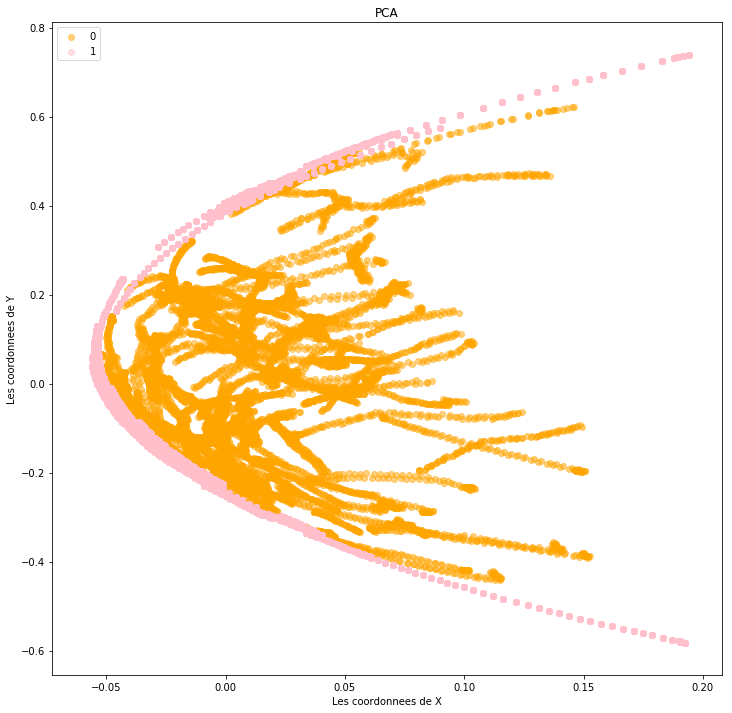

In [36]:
def visualize_pca_axis(X, y, axis1, axis2):
    plt.figure(figsize=(12,12))

    plt.scatter(X[y==0, axis1], X[y==0, axis2], color='orange', alpha=0.5,label='0')
    plt.scatter(X[y==1, axis1], X[y==1, axis2], color='pink', alpha=0.5,label='1')
    plt.title("PCA")
    plt.ylabel('Les coordonnees de Y')
    plt.xlabel('Les coordonnees de X')
    plt.legend()
    plt.show()

visualize_pca_axis(X_pca_train, y_train, 3, 0)

## Correlation Analysis

In [ ]:
def draw_correlation_matrix(X):
    df = pd.DataFrame(X)
    corr = df.corr()
    print(corr[corr > .5].count().sum())
    return corr.style.background_gradient(cmap='coolwarm')


In [ ]:
# draw_correlation_matrix(X_test_proper_cp)
draw_correlation_matrix(X_train_cp)

## Classifier Evaluations

In [37]:
def draw_confussion_matrix(data):
    df_cm = pd.DataFrame(data, columns=np.unique(y_test_proper), index = np.unique(y_test_proper))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [38]:
def evaluate_classifier(clf, X, y):
    score = clf.score(X, y)
    y_predict = clf.predict(X)
    
#     a,b = np.unique(y_predict_proper, return_counts=True)
#     print(a)
#     print(b)
    
    precision, recall, _, _ = precision_recall_fscore_support(y, y_predict, average='binary')
    f1 = f1_score(y, y_predict)
    print('{:.3f}, {:.3f}, {:.3f}, {:.3f}'.format(score, int(precision*1000)/1000, int(recall*1000)/1000, int(f1*1000)/1000))
    
    data = confusion_matrix(y, y_predict)
    draw_confussion_matrix(data)
    
    return score, (int(precision*1000)/1000, int(recall*1000)/1000, int(f1*1000)/1000)

## Classifiers

In [39]:
svmClf = SVC(gamma='auto')
advancedSvmClf = SVC(gamma='auto', kernel='rbf', probability=True, class_weight='balanced', C=120000000)
ridgeClf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
randomForestClf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=0)
gradientBoostClf = GradientBoostingClassifier(n_estimators=200, max_depth=7, random_state=0)
xgbClf = XGBClassifier(n_estimators=500, max_depth=5)
adaBoostClf = AdaBoostClassifier()
lgbmClf = LGBMClassifier(n_estimators=1000)


0.997, 0.995, 0.971, 0.983


['./checkpoints/lgbmclassifier.joblib.pkl']

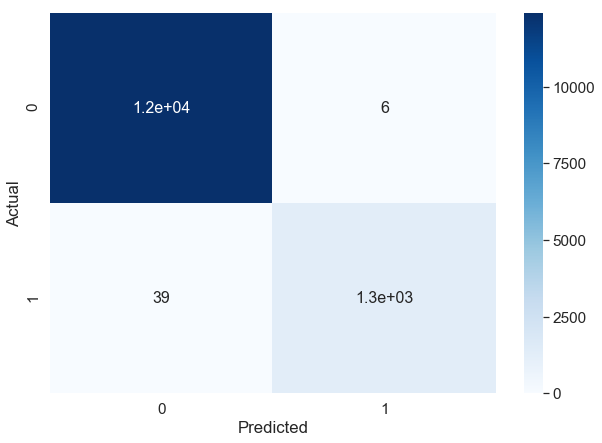

In [40]:
clf = lgbmClf
clf.fit(X_pca_train, y_train) 
evaluate_classifier(clf, X_pca_test_proper, y_test_proper)
joblib.dump(clf, './checkpoints/lgbmclassifier.joblib.pkl', compress=9)

# Other

In [ ]:
X_pca_train.shape